# ML - Final - 2023

## Instruction

- Modify this file to be Final-<Your FirstName-[First Letter of Last Name]>, e.g., <code>Final-Chaklam-S.ipynb</code>
- This exam is open-booked; open-internet, but no interactions with human beings or ChatGPT.
- The completed exams shall be submitted at the virtual learning environment.
- All code should be **complemented with comments**, unless it's really obvious.  **We reserve the privilege to give you zero for any part of the question where the benefit of doubt is not justified**

# Coding

#### Summary
In this section, you will be dealing with a classification problem. You will be generating your own data, training and evaluating them. You will be asked to create a neural network according to the instructions.

The generating data will be a 2d-data `(28, 28)` being arranged similar to the input shape of `nn.Conv2d` with channel = 1, height = 28 and width = 28 `(batch_size, channel, height, width)`

You will then be asked to create a network consisting of 2 `nn.Conv2d` layers followed by a `nn.Linear` layer. After the `nn.Linear` layer, we send the data to a `nn.LSTM` layer where `num_layer` and `hidden_size` can be defined. This `hidden_size` is set to be the same as `num_classes`. The output of lstm is then directly returned.

Import Libraries

In [1]:
import torch
import torch.nn as nn #defining neural network
import torch.nn.functional as F #helper
from torch.utils.data import  TensorDataset,DataLoader #batching
from torchvision import datasets, transforms #loading datasets
from torchvision.utils import make_grid  #for visualization

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os

1. Generate a 4 class 2d-data with 70000 samples. (10 points)
- Class 0 data is sampled from a normal distribution with mean = 0, std = 1, size = `(28,28)`
- Class 1 data is sampled from a normal distribution with mean = 5, std = 1, size = `(28,28)`
- Class 2 data is sampled from a normal distribution with mean = 15, std = 1, size = `(28,28)`
- Class 3 data is sampled from a normal distribution with mean = 20, std = 1, size = `(28,28)`

The final shape of *x* should be `(70000, 1, 28, 28)` and *y* should be `(70000,)`

In [2]:
cond = [(5,1),(15,1),(20,1)]
s = np.random.normal(0, 1,28*28*17500)
X_sample = s.reshape(17500,1,28,28)
Y_sample = np.array([0]*17500)

for i in range(len(cond)):
    s = np.random.normal(cond[i][0], cond[i][1],28*28*17500)
    X_sample = np.append(X_sample,s.reshape(17500,1,28,28),axis=0)
    Y_sample = np.append(Y_sample,np.array([i+1]*17500))


In [3]:
X_sample.shape,Y_sample.shape

((70000, 1, 28, 28), (70000,))

In [4]:
X_sample =torch.Tensor(X_sample)
Y_sample = torch.Tensor(Y_sample)
training_data = TensorDataset(X_sample,Y_sample) 

In case you are unable to do question 1, Use the following lines of code to generate your data and continue with question 3. But be aware that no marks will be given to question 1 and question 2

2. Split your data into train and test with the split ratio of 1/7 (5 points)

In [5]:
len(training_data)

70000

In [6]:
test_size = int(len(training_data)/7)

train_set,test_set = torch.utils.data.random_split(training_data,[len(training_data)-test_size,test_size])

3. Check the size of your train and test sets (5 points)

In [7]:
len(train_set),len(test_set)

(60000, 10000)

4. Set up your train and test loader with a batch size of 32 and `shuffle = True` (10 points)

In [8]:
train_loader = DataLoader(train_set,batch_size = 32,shuffle=True)
test_loader = DataLoader(test_set,batch_size = 8571,shuffle=False) # no need to shuffle and batch cuda will not out of memory because no grad cal



5. Check the shape of your batch. It should be `[batchsize = 32, channel = 1, height = 28, width = 28]` (5 points)

torch.Size([32, 1, 28, 28])
torch.Size([32])


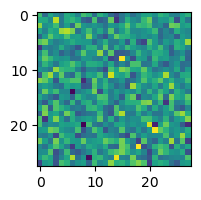

In [9]:
for image, label in train_loader:
    print(image.shape) # (bs,ch,h,w)
    print(label.shape) 

    norm = image[0] # np.transpose(image,(0,1,3,2))
    plt.figure(figsize = (2,2))
    plt.imshow(np.transpose(norm, (1,2,0)))
    
    break

6. Plot 6 samples of any classes (10 points)

torch.Size([1, 28, 28])
torch.Size([])


torch.Size([1, 28, 28])
torch.Size([])
torch.Size([1, 28, 28])
torch.Size([])
torch.Size([1, 28, 28])
torch.Size([])
torch.Size([1, 28, 28])
torch.Size([])
torch.Size([1, 28, 28])
torch.Size([])


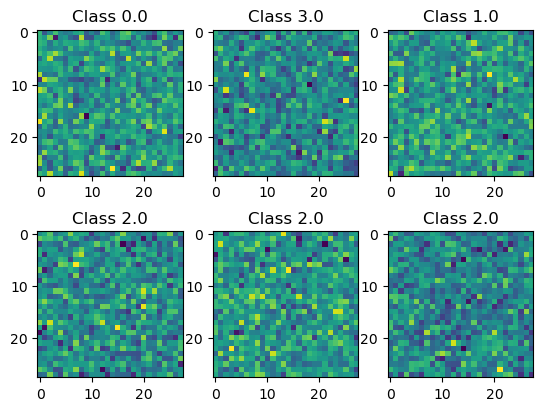

In [10]:

for image, label in train_loader:

    c = 0
    for im,l in zip(image,label):
        print(im.shape) # (bs,ch,h,w)
        print(l.shape) 
        norm = im # np.transpose(image,(0,1,3,2))
        plt.subplot(2, 3, c+1)
        plt.imshow(np.transpose(norm, (1,2,0)))
        plt.title(f"Class {l.item()}")

        c+=1

        if c==6:
            break
    break

7. Configure your device. (5 points)

In [11]:
device = torch.device("cpu")

8. Define your class called `Net` with the following layers (40 points)
- cnn2d layer 1 with `in_channel = 1`, `out_channel = 10`, `kernel size = 5`, dropout of `p = 0.5`, `maxpool` and `relu` as its activation function
- cnn2d layer 2 with `in_channel = 10`, `out_channel = 20`, `kernel size = 5`, dropout of `p = 0.5`, `maxpool` and `relu` as its activation function
- linear layer with output of 25
- lstm with `num_layer = 2` and set hidden size to be num_classes




In [12]:
class Net(nn.Module):

    def __init__(self,num_class,num_layers=2):
        super().__init__()

        self.conv1 =nn.Conv2d(1,10,5,padding=2) # i set pad to 2 because i want outputsize to be the same
        self.conv2 =nn.Conv2d(10,20,5,padding=2)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm1 = nn.BatchNorm2d(10, affine=False)
        self.batch_norm2 = nn.BatchNorm2d(20, affine=False)

        # output 28,28 but 2 maxpool = /4 => 7,7
        self.fc = nn.Linear(7*7*20,25)
        self.lstm = nn.LSTM(25,num_class,num_layers=num_layers) # 0-9


    def forward(self,X):

        X = F.relu(self.batch_norm1(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        # X = self.batch_norm1(X)
        # X = self.dropout(X)

        X = F.relu(self.batch_norm2(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)
        # X = self.batch_norm2(X)
        # X = self.dropout(X)

        X = X.view(-1, 7*7*20)
        X = F.relu(self.fc(X))

        out,_ = self.lstm(X)

        return out

9. Create a model object with `num_layers of lstm = 2`, `hidden_size` and `num_classes = 4` (10 points)

If you use MNIST hidden_size and  `num_classes = 10`


In [13]:
param = {"num_layers":2,"num_class":4}

model =  Net(**param)

In [14]:
len(image)

32

In [15]:
# test
output  = model(image)
print(output.shape)

assert output.shape[1] == 4

torch.Size([32, 4])


In [16]:
model.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (batch_norm2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (fc): Linear(in_features=980, out_features=25, bias=True)
  (lstm): LSTM(25, 4, num_layers=2)
)

10. Define an appropriate loss function for classification of this dataset (2.5 points)

In [17]:
criterion = nn.CrossEntropyLoss()

11. Define your optimizer as `Adam` with learning rate of `0.001` (5 points)

In [18]:
optim     = torch.optim.Adam(model.parameters(), lr=0.001)

12. Define your train function and train your model with `n_epoch = 3` (15 points)

In [19]:
num_epochs = 3

loss_history = []
accuracy_history = []
for i in range(num_epochs):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0


    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.type(torch.LongTensor).to(device)
        y_hat = model(images)
        loss = criterion(y_hat, labels)

        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()
        total_correct += (torch.max(y_hat, 1)[1] == labels).sum().item()
        total_samples += len(images)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = (total_correct / total_samples) * 100

    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_acc)

    print(f"Epoch: {i} | Train acc: {epoch_acc:3.2f} | Loss: {epoch_loss:3.4f}")


Epoch: 0 | Train acc: 80.73 | Loss: 0.8481
Epoch: 1 | Train acc: 99.87 | Loss: 0.5607
Epoch: 2 | Train acc: 99.50 | Loss: 0.5132


13. Plot your train losses and accuracies (10 points)

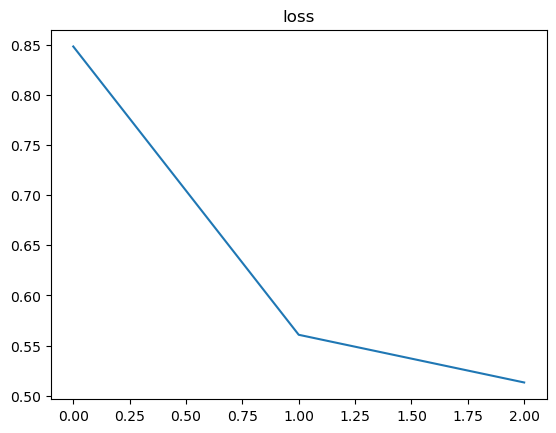

In [20]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title("loss")
plt.show()

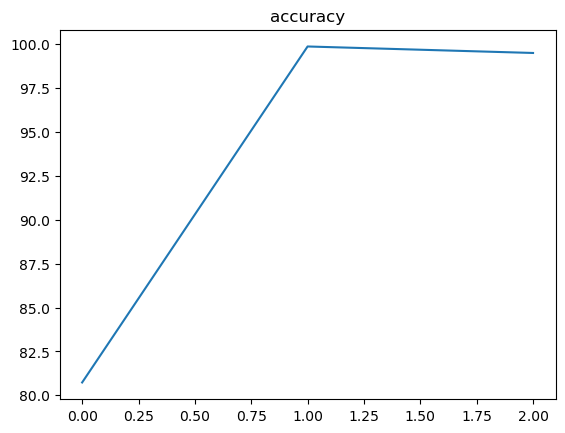

In [21]:
import matplotlib.pyplot as plt

plt.plot(accuracy_history)
plt.title("accuracy")
plt.show()

14. Evaluate your model with your test set (10 points)

In [22]:
from torch import nn

criterion = nn.CrossEntropyLoss()


with torch.no_grad(): 
    for images, labels in test_loader:
        y_hat = model(images)
        labels = labels.type(torch.LongTensor)
        loss = criterion(y_hat,labels)

        test_loss = loss.item()
        y_hat_pred =  torch.max(y_hat, 1)[1]
        test_correct = (y_hat_pred == labels).sum().item()
        test_samples = len(images)

    
print(f"Test | Accuacy: {(test_correct / test_samples) * 100:3.2f} | Loss: {test_loss / len(test_loader)}")

Test | Accuacy: 100.00 | Loss: 0.24371188879013062
